<a href="https://colab.research.google.com/github/rootAkash/A.I.-AND-ROBOTS/blob/master/worldmodels_for_AD_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive

/gdrive/My Drive


In [ ]:
#for extracting the compressed file , dont run after extracting
#!tar -xvf '/gdrive/My Drive/Copy of CARLA_challenge_autopilot.tar.gz' -C '/gdrive/My Drive/'


In [ ]:
%cd /gdrive/MyDrive/Drive/CARLA_challenge_autopilot
!ls

/gdrive/MyDrive/Drive/CARLA_challenge_autopilot
route_00_04_06_00_33_32  route_26_04_09_11_32_35  route_52_04_06_12_08_06
route_01_04_06_00_38_28  route_27_04_08_18_05_04  route_53_04_08_22_03_01
route_02_04_06_00_43_36  route_28_04_08_18_21_14  route_54_04_06_12_27_40
route_03_04_06_00_48_16  route_29_04_09_11_47_17  route_55_04_08_22_12_04
route_04_04_06_00_57_15  route_30_04_06_06_59_30  route_56_04_06_12_46_43
route_05_04_06_01_02_59  route_31_04_08_19_10_16  route_57_04_08_22_20_30
route_06_04_06_01_09_46  route_32_04_08_19_26_38  route_58_04_06_13_10_46
route_07_04_07_22_31_01  route_33_04_06_08_02_37  route_59_04_06_13_26_15
route_08_04_06_01_21_41  route_34_04_06_08_18_08  route_60_04_08_22_39_20
route_09_04_07_23_07_09  route_35_04_08_19_42_06  route_61_04_06_13_54_28
route_10_04_06_01_34_50  route_36_04_08_20_00_21  route_62_04_08_22_52_34
route_11_04_08_13_52_45  route_37_04_08_20_25_33  route_63_04_08_23_17_48
route_12_04_09_10_05_34  route_38_04_08_20_44_24  route_64_04_08

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import math
import os
import cv2
#!pip install circle-fit
#import circle_fit as cf

def read_json_better(data_path):
  with open(data_path, 'r') as f2:
    data = f2.read()  
  f2.close()  
 
  data = data[1:-1].split(",")
  d = []
  for p in range(len(data)-1):
    d.append(float(data[p].split(":")[1]))
  #print("brake " , data[len(data)-1].split(":")[1])
  if data[len(data)-1].split(":")[1] == " True":
    d.append(True)  
  else:
    d.append(False)
  #returns [x,y,theta,speed,target_speed,x_command,y_command,command,steer,throttle,brake]  
 
  return d  
def get_max(files):
  max = 0
  l=0
  for f in files:
    n = int(f.split(".")[0])
    
    if n>max:
      l = len(f.split(".")[0])
      max=n
  return max,l    
def get_string(num,l):
  n = str(num)
  new=""
  for i in range(l-len(n)):
    new+="0"
  new+=n
  return new  
 
 
cmap = {
    0: np.array([0, 0, 0], dtype=np.uint8),
    1: np.array([0, 127, 180], dtype=np.uint8),
    2: np.array([127, 40, 127], dtype=np.uint8),
    3: np.array([80, 180, 80], dtype=np.uint8),
    4: np.array([255, 127, 127], dtype=np.uint8),
    5: np.array([180, 180, 180], dtype=np.uint8),
    6: np.array([255, 180, 0], dtype=np.uint8),
    7: np.array([255, 255, 0], dtype=np.uint8),
    8: np.array([255, 0, 255], dtype=np.uint8),
    9: np.array([0, 255, 0,], dtype=np.uint8),
    10: np.array([0, 0, 255], dtype=np.uint8),#car
    11: np.array([127, 40, 127], dtype=np.uint8),
    12: np.array([255, 0, 0], dtype=np.uint8),
    -1: np.array([255, 255, 255], dtype=np.uint8)
}
def map_semseg_colors(ss, cmap,cat=None):
    result = np.empty(list(ss.shape[:2])+[3], np.uint8)
    for r in range(ss.shape[0]):
        for c in range(ss.shape[1]):
          if cat is None:
            if ss[r, c, 0] <13:
              result[r, c] = cmap[ss[r, c, 0]]
            else:
              result[r, c] = cmap[-1]
          else:
            if ss[r, c, 0] ==cat:
              result[r, c] = cmap[-1]
            else:
              result[r, c] = cmap[0]  

 
    return result
 
def dist(x1,y1,x2,y2):
  dist = ((x1-x2)**2 + (y1-y2)**2)**0.5
  if dist < 0.001:
    return 0.0
  return dist
 
 
def next_chk_top(top_view,chkx,chky,currx,curry,theta,thickness=-1,chk_theta=None):
  #i coord = 4.5 pixel
  theta = -theta
  #print(chkx,chky,currx,curry,theta)
  y = chky - curry
  x = chkx - currx
  xnew = x*math.cos(theta) - y*math.sin(theta)
  ynew = x*math.sin(theta) + y*math.cos(theta)
  h = top_view.shape[0]
  w = top_view.shape[1]#85,42
  pos = [int(xnew*4.5),int(ynew*4.5),None]
  Y = h//2-int(xnew*4.5)
  X = w//2+int(ynew*4.5)
  #top_view = cv2.circle(top_view,(w//2,h//2),4,(0,0,0),-1)
  #print(h,w,xnew,ynew,(X,Y))
  top_view = cv2.circle(top_view,(X,Y),4,(0,255,255),thickness)
  if chk_theta is not None:
    chk_theta =-chk_theta
    arrowlen = 200#in pixels
    del_theta = chk_theta-theta +math.pi/2
    end_point = (X+int(arrowlen*math.cos(del_theta)),Y-int(arrowlen*math.sin(del_theta)))
    top_view = cv2.arrowedLine(top_view,(X,Y), end_point,(0,0,50), thickness=10) 
    pos[2]=(del_theta*180/math.pi)%360
  return top_view,pos
 
def visualise_check(pos,front,col=(0,255,0)):
  #z is assumed to be camera center height and fov = 90 deg
  x = pos[1]
  y= pos[0]
  
  fov = 90
  w = front.shape[1]
  h = front.shape[0]
  z = -9
  fovy = 90*h/w
  fx = (w/2)*math.tan((90-fov/2)*math.pi/180)
  fy =  (h/2)*math.tan((90-fovy/2)*math.pi/180)
  newx = (abs(x)*fx)/(abs(y)+0.001)
  newz = (abs(z)*fy)/(abs(y)+0.001)
  yf = h//2
  if x<0:
    xf = np.clip(int(w/2 - newx),0,w//2)
  if x>=0:
    xf = np.clip(int(w/2 + newx),w//2,w)
  if z>=0:
    zf = np.clip(int(h/2 - newz),0,h//2)
  if z<0:
    zf = np.clip(int(h/2 + newz),h//2,h)
  if y<0:
    yf = h-1     
  front = cv2.circle(front,(xf,yf),int(newz),col,-1)
  return front
def visualise_way(pos,front,col=(0,255,255),visual=True):
  #to convert a point in top view/coordinate/gps wrt to ego into front view
  #z is assumed to be camera center height and fov = 90 deg
  x = pos[1]
  y= pos[0]
  
  fov = 90
  w = front.shape[1]
  h = front.shape[0]
  z = -9
  fovy = 90*h/w
  fx = (w/2)*math.tan((90-fov/2)*math.pi/180)
  fy =  (h/2)*math.tan((90-fovy/2)*math.pi/180)
  newx = (abs(x)*fx)/(abs(y)+0.001)
  newz = (abs(z)*fy)/(abs(y)+0.001)
  yf = h//2
  if x<0:
    xf = np.clip(int(w/2 - newx),0,w//2)
  if x>=0:
    xf = np.clip(int(w/2 + newx),w//2,w)
  if z>=0:
    zf = np.clip(int(h/2 - newz),0,h//2)
  if z<0:
    zf = np.clip(int(h/2 + newz),h//2,h-5)
  if y<0:
    yf = h-1     
  if visual:  
    front = cv2.circle(front,(xf,zf),5,col,-1)
  return front,(xf,zf)
def fit_nd_show_circle(top,data):
  xc,yc,r,_ = cf.least_squares_circle((data))
  h = top.shape[0]
  w = top.shape[1]
  Y = h//2-int(yc)
  X = w//2+int(xc) 
  top = cv2.circle(top,(X,Y),int(r),(0,0,0),1)
  
  return top,(xc,yc,r)
def fit_lines(image,data,color=(255,255,255), thickness=20):
  #data is a list of [(x,y) ] the actual pixel coordinates to be connected by lines
  for i in range(len(data)-1):
    image = cv2.line(image, data[i],data[i+1], color, thickness)   
  return image

for f in os.listdir("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot"):
  files =os.listdir("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/measurements")
  m,n = get_max(files)
  print(f,m,n)
#/gdrive/MyDrive/world_model/train/future_occupancy
#/gdrive/MyDrive/world_model/train/raw_history
#/gdrive/MyDrive/world_model/train/waypoints

route_00_04_06_00_33_32 471 4
route_01_04_06_00_38_28 460 4
route_02_04_06_00_43_36 0 0
route_03_04_06_00_48_16 825 4
route_04_04_06_00_57_15 462 4
route_05_04_06_01_02_59 633 4
route_06_04_06_01_09_46 541 4
route_08_04_06_01_21_41 472 4
route_10_04_06_01_34_50 970 4
route_13_04_06_02_12_16 1297 4
route_14_04_06_02_27_29 642 4
route_30_04_06_06_59_30 855 4
route_33_04_06_08_02_37 1172 4
route_34_04_06_08_18_08 1066 4


FileNotFoundError: ignored

In [ ]:
train_routes=["route_10_04_06_01_34_50","route_13_04_06_02_12_16","route_14_04_06_02_27_29","route_30_04_06_06_59_30","route_33_04_06_08_02_37","route_34_04_06_08_18_08","route_00_04_06_00_33_32","route_02_04_06_00_43_36"]
test_routes=["route_03_04_06_00_48_16","route_04_04_06_00_57_15","route_05_04_06_01_02_59","route_06_04_06_01_09_46" ]
testing = ["route_03_04_06_00_48_16"]

KeyboardInterrupt: ignored

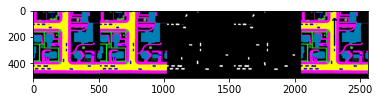

In [ ]:
look_ahead= 10
history =4 #s-n to s-1
ctr = 0 
currfol = os.listdir("/gdrive/MyDrive/world_model/test/waypoints/")
current_ctr = len(currfol) # use it to resume data generation even after getting disconnected
print("starting from ",current_ctr )
for f in test_routes:
  files =os.listdir("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/measurements")
  m,n = get_max(files)
  for i in range(history,m+1-look_ahead):
    print(i)
    hist_raw =[]
    for k in range(i-history,i):
      simdata0 = read_json_better("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/measurements/"+get_string(k,n)+".json")
      top0 =cv2.imread("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/topdown/"+get_string(k,n)+".png")
      top0 = cv2.cvtColor(top0, cv2.COLOR_BGR2RGB)
      hist_raw.append(map_semseg_colors(top0,cmap))
    name = get_string(i,n)#current state
    jf ="/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/measurements/"+name+".json"
    simdata = read_json_better(jf)#[x 0 ,y 1 ,theta(rad) 2 ,speed 3 ,target_speed 4 ,x_command 5 ,y_command 6 ,command 7 ,steer 8 ,throttle 9 ,brake 10 ]
    if simdata is None:
      print("empty")
      break
    top =cv2.imread("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/topdown/"+name+".png")
    top = cv2.cvtColor(top, cv2.COLOR_BGR2RGB)      
    hist_raw.append(map_semseg_colors(top,cmap))
    occupancy =[]
    traj =[]
    cars = map_semseg_colors(top,cmap,cat=10)
    occupancy.append(cars)
    traj.append([0,0,90])
    
    top_wp=hist_raw[-1].copy()
    top_wp,chkpos = next_chk_top(top_wp,simdata[5],simdata[6],simdata[0],simdata[1],simdata[2],thickness=8)# put checkpoint
    for j in range(i+1,i+1+look_ahead):
      simdata1 = read_json_better("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/measurements/"+get_string(j,n)+".json")
      top_wp,pos = next_chk_top(top_wp,simdata1[0],simdata1[1],simdata[0],simdata[1],simdata[2],thickness=-1,chk_theta=simdata1[2])
      #rgb,points = visualise_way(pos,rgb,(255,255,255),False)#to visualise in front view
      #pos = delta Y, delta X wrt to car , where y is front axis and x is perpendicular to front axis in ground plane,origin is center
      #points = x,y,(z) wrt to front view of car
      traj.append(pos)#y,x,theta
      top1 =cv2.imread("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/topdown/"+get_string(j,n)+".png")
      top1 = cv2.cvtColor(top1, cv2.COLOR_BGR2RGB)
      cars1 = map_semseg_colors(top1,cmap,cat=10)
      occupancy.append(cars1)
    print(traj,len(traj))
    img = np.hstack(hist_raw[-2:]+occupancy[:2]+[top_wp])
    plt.imshow(img)
    hist_raw = np.array(hist_raw)
    occupancy = np.array(occupancy)    
    traj = np.array(traj)   
    print(hist_raw.shape,occupancy.shape,traj.shape)
    np.save('/gdrive/MyDrive/world_model/test/future_occupancy/'+str(ctr)+'.npy',occupancy)
    np.save('/gdrive/MyDrive/world_model/test/raw_history/'+str(ctr)+'.npy',hist_raw)
    np.save('/gdrive/MyDrive/world_model/test/waypoints/'+str(ctr)+'.npy',traj)
    ctr+=1

     
    #distc =dist(simdata[0],simdata[1],simdata[5],simdata[6])
    #print("next :",int(simdata[5]),int(simdata[6]),"distace to next :",distc,"| pose :",int((simdata[2]*180/np.pi)%360),"| action :",simdata[7],"| s t b : ",simdata[8],simdata[9],simdata[10])
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

print("final_ctr",ctr)    

In [ ]:
#make it anti turn

KeyboardInterrupt: ignored

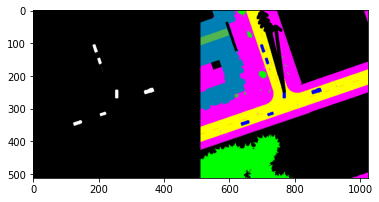

In [ ]:
 
look_ahead= 5
#route_16_04_08_16_05_14
for f in os.listdir("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot"):
  files =os.listdir("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/measurements")
  m,n = get_max(files)
  for i in range(m+1-look_ahead):
    name = get_string(i,n)
    traj =[]
    jf ="/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/measurements/"+name+".json"
 
    simdata = read_json_better(jf)#[x 0 ,y 1 ,theta(rad) 2 ,speed 3 ,target_speed 4 ,x_command 5 ,y_command 6 ,command 7 ,steer 8 ,throttle 9 ,brake 10 ]
 
    #if int(simdata[7]) !=6:
    #  continue
    rgb=cv2.imread("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/rgb/"+name+".png")
    top =cv2.imread("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/topdown/"+name+".png")
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    top = cv2.cvtColor(top, cv2.COLOR_BGR2RGB) 
         
    top_crop = top#[top.shape[0]//2-rgb.shape[0]//2:top.shape[0]//2+rgb.shape[0]//2,top.shape[0]//2 - rgb.shape[1]//2:top.shape[0]//2+rgb.shape[1]//2]
    cars = map_semseg_colors(top_crop,cmap,cat=10)
    #print(top_crop[top_crop.shape[0]//2,top_crop.shape[1]//2])
    top_crop,chkpos = next_chk_top(top_crop,simdata[5],simdata[6],simdata[0],simdata[1],simdata[2],thickness=8)# put checkpoint
    #rgb = visualise_check(chkpos,rgb)#,(255,255,255))
    for j in range(look_ahead):
 
      simdata1 = read_json_better("/gdrive/MyDrive/Drive/CARLA_challenge_autopilot/"+f+"/measurements/"+get_string(i+1+j,n)+".json")
      top_crop,pos = next_chk_top(top_crop,simdata1[0],simdata1[1],simdata[0],simdata[1],simdata[2],thickness=-1,chk_theta=simdata1[2])
      #rgb,points = visualise_way(pos,rgb,(255,255,255),False)#to visualise in front view
      #pos = delta Y, delta X wrt to car , where y is front axis and x is perpendicular to front axis in ground plane,origin is center
      #points = x,y,(z) wrt to front view of car
      traj.append(pos)#y,x
    top_crop = map_semseg_colors(top_crop,cmap)
    print(traj)
 
 
    #img = np.hstack([rgb_left,rgb,rgb_right,top_crop])
    img = np.hstack([cars,top_crop])
    plt.imshow(img)
    
    if simdata is None:
      print("empty")
      break
    distc =dist(simdata[0],simdata[1],simdata[5],simdata[6])
    #print("next :",int(simdata[5]),int(simdata[6]),"distace to next :",distc,"| pose :",int((simdata[2]*180/np.pi)%360),"| action :",simdata[7],"| s t b : ",simdata[8],simdata[9],simdata[10])
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

In [ ]:
4 = lane keep 
3 straight
1= left
2 = right
5= left lane
6 = right lane

In [ ]:
comm_cnt={1.0:0,2.0:0,3.0:0,4.0:0,5.0:0,6.0:0}
for f in os.listdir("/gdrive/My Drive/CARLA_challenge_autopilot"):
  if len(os.listdir("/gdrive/My Drive/CARLA_challenge_autopilot/"+f))==0:
    print("empty",f)
    continue
  files =os.listdir("/gdrive/My Drive/CARLA_challenge_autopilot/"+f+"/measurements")
  m,n = get_max(files)
  if n ==0:
    print("empty",f)
    continue
  for i in range(m+1):
    name = get_string(i,n)
    jf ="/gdrive/My Drive/CARLA_challenge_autopilot/"+f+"/measurements/"+name+".json"
    with open(jf, 'r') as f2:
      data = f2.read()
    simdata = read_json_better(data)#[x 0 ,y 1 ,theta 2 ,speed 3 ,target_speed 4 ,x_command 5 ,y_command 6 ,command 7 ,steer 8 ,throttle 9 ,brake 10 ]
    comm_cnt[simdata[7]]+=1
  print(f,comm_cnt)  
print(comm_cnt)    

route_00_04_06_00_33_32 {1.0: 21, 2.0: 6, 3.0: 0, 4.0: 445, 5.0: 0, 6.0: 0}
route_01_04_06_00_38_28 {1.0: 21, 2.0: 26, 3.0: 7, 4.0: 879, 5.0: 0, 6.0: 0}
empty route_02_04_06_00_43_36
route_03_04_06_00_48_16 {1.0: 44, 2.0: 52, 3.0: 32, 4.0: 1631, 5.0: 0, 6.0: 0}
route_04_04_06_00_57_15 {1.0: 59, 2.0: 64, 3.0: 46, 4.0: 2053, 5.0: 0, 6.0: 0}
route_05_04_06_01_02_59 {1.0: 90, 2.0: 81, 3.0: 53, 4.0: 2632, 5.0: 0, 6.0: 0}
route_06_04_06_01_09_46 {1.0: 111, 2.0: 104, 3.0: 53, 4.0: 3130, 5.0: 0, 6.0: 0}
route_08_04_06_01_21_41 {1.0: 111, 2.0: 125, 3.0: 61, 4.0: 3574, 5.0: 0, 6.0: 0}
route_10_04_06_01_34_50 {1.0: 142, 2.0: 136, 3.0: 87, 4.0: 4423, 5.0: 54, 6.0: 0}
route_13_04_06_02_12_16 {1.0: 176, 2.0: 151, 3.0: 265, 4.0: 5480, 5.0: 60, 6.0: 8}
route_14_04_06_02_27_29 {1.0: 200, 2.0: 174, 3.0: 305, 4.0: 6033, 5.0: 63, 6.0: 8}
route_30_04_06_06_59_30 {1.0: 200, 2.0: 174, 3.0: 423, 4.0: 6756, 5.0: 71, 6.0: 15}
route_33_04_06_08_02_37 {1.0: 200, 2.0: 174, 3.0: 690, 4.0: 7655, 5.0: 74, 6.0: 19}
ro

In [ ]:
print(comm_cnt)